#HW 10 CLUSTERING BUSINESS

#cluster time trends in NYC businesses: 
#DATA
#Census Business data:
##download census data for businesses by ZIP code. the data is here
http://www.census.gov/econ/cbp/download/
##and it can be downloaded by hand. you can also download it with 3 terminal commands as follows: the data from 1993 through 2001 is different in the format of its path than the data after 2001 (that is why more than one for loop is needed)



TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

In [1]:
kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    #Repeat Again for last part
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

In [2]:
# $ for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

# $ for ((y=0; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

# $ for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done


#NYC zip codes shape file is here
##http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981


NOTES: 
to read in a zip file without unzipping it you can use the pandas and zipfile packages

In [3]:
import pandas as pd
import zipfile 
import glob, os
import numpy as np
import pylab as pl
import json
np.random.seed(1976)

%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [4]:
nyc_sf = json.load(open('nyc-zip-code-tabulation-areas-polygons.geojson'))

nyc_zip = []
for department in nyc_sf['features']:
    nyc_zip.append(str(department['properties']["postalCode"]))

In [5]:
os.chdir(".")

fname = "zbp00totals.zip"
zf = zipfile.ZipFile(fname)
dfz = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
dfz = dfz.rename(columns={'zip': 'ZIP', 'est': 'EST'})
dfze = dfz[['ZIP', 'EST']]
dfze = dfze[(dfze.ZIP.astype(str).isin(nyc_zip))]
dfze['YEAR'] = 2000

for fname in glob.glob("*.zip"):
    if fname == "zbp00totals.zip":
        continue
    zf = zipfile.ZipFile(fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    df = df.rename(columns={'zip': 'ZIP', 'est': 'EST'})
    df = df[['ZIP', 'EST']]
    df = df[(df.ZIP.astype(str).isin(nyc_zip))]
    if int(fname[3:5]) > 93:
        df['YEAR'] = int('19' + fname[3:5])
    else:
        df['YEAR'] = int('20' + fname[3:5])
    dfze = dfze.append(df, ignore_index=True)

In [6]:
dfez = dfze.pivot_table('EST',['ZIP'],'YEAR')

In [7]:
# WHITENING DATA
wdfez = dfez.copy()
for i in range(len(dfez)):
    wdfez.iloc[i] = (wdfez.iloc[i]-np.mean(wdfez.iloc[i]))/np.std(wdfez.iloc[i])

In [8]:
# CHECK WITH RANDOM ZIP
rndzip = np.random.choice(np.array(wdfez.index))
print "zip: %s" %(rndzip)
print("STD = {0}".format(np.std(wdfez.loc[rndzip])))
print("MEAN = {0:.2f}".format(np.mean(wdfez.loc[rndzip])))

zip: 10304
STD = 1.0
MEAN = 0.00


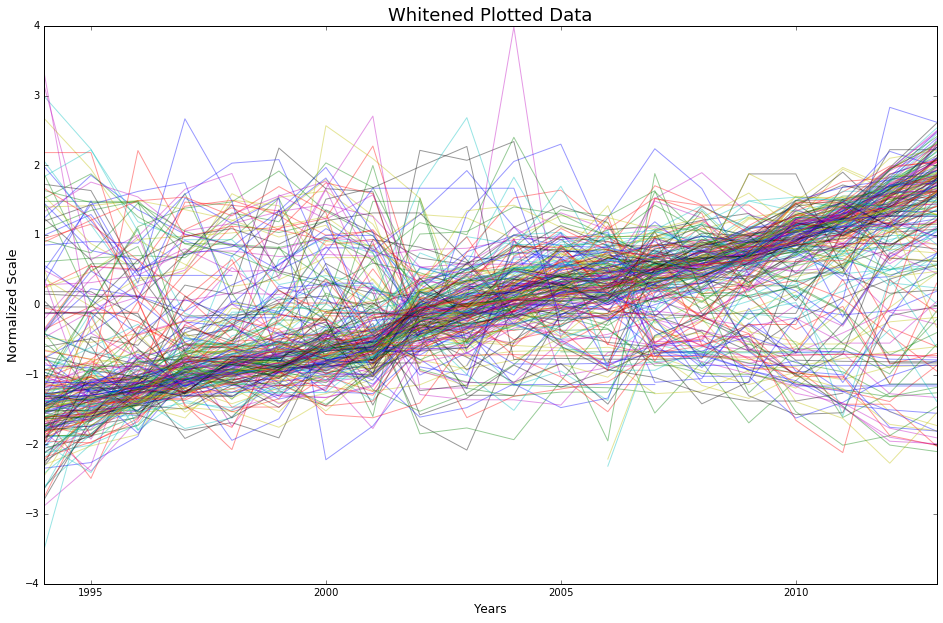

In [9]:
plt.figure(figsize=(16,10))
plt.xlim(1994,2013)
plt.title('Whitened Plotted Data',fontsize=18)
plt.xlabel('Years',fontsize=12)
plt.ylabel('Normalized Scale',fontsize=13)
for i in range(len(wdfez)):
    plt.plot(wdfez.iloc[i].index, wdfez.iloc[i], '-', alpha=0.4)

In [10]:
import sklearn.cluster
from sklearn import mixture
from PIL import Image
from scipy.misc import imread
from scipy.cluster.vq import kmeans2
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AffinityPropagation
from descartes import PolygonPatch

In [11]:
wdfez.head()

YEAR       1994      1995      1996      1997      1998      1999      2000  \
ZIP                                                                           
10001 -1.831632 -1.173250 -1.269418 -0.685012  0.054742 -0.100607  0.520787   
10002 -1.722813 -1.631907 -1.372173 -1.034519 -1.153997 -0.941015 -0.442326   
10003 -1.872528 -1.457250 -1.319968 -0.914985 -0.523731 -0.489411 -0.407041   
10004 -1.608897 -1.523770 -1.438643 -1.060302 -1.031926 -0.492790  0.084181   
10005 -2.885957 -2.304004 -0.417066 -0.223082  0.535220  0.041442  0.835014   

YEAR       2001      2002      2003      2004      2005      2006      2007  \
ZIP                                                                           
10001 -0.433496 -0.781180 -1.202840  0.912857  0.483799  1.245746  2.237017   
10002  0.248565 -0.463105 -0.117659  0.269344  0.609595  0.619984  0.617387   
10003 -0.685038 -0.636989 -0.334968 -0.087861  0.224456  0.368602  0.849090   
10004 -0.360370 -0.303619 -0.313078 -0.019863 -0.237409  0.244976  0.803030   
10005  0.164887  0.076712 -0.699225 -0.240717 -0.452336  0.341236  0.588125   

YEAR       2008      2009      2010      2011      2012      2013  
ZIP                                                                
10001  1.667406  0.432016 -0.041426 -0.144992 -0.085811  0.195295  
10002  0.632971  0.851147  1.103089  1.206982  1.316071  1.404380  
10003  0.924595  1.020693  1.068741  1.226616  1.415379  1.631598  
10004  0.859781  0.888157  1.067869  1.124620  1.484044  1.834010  
10005  0.905554  0.605760  0.464681  1.081903  0.588125  0.993729

In [12]:
wdfez = wdfez.dropna()

/Users/arp504/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


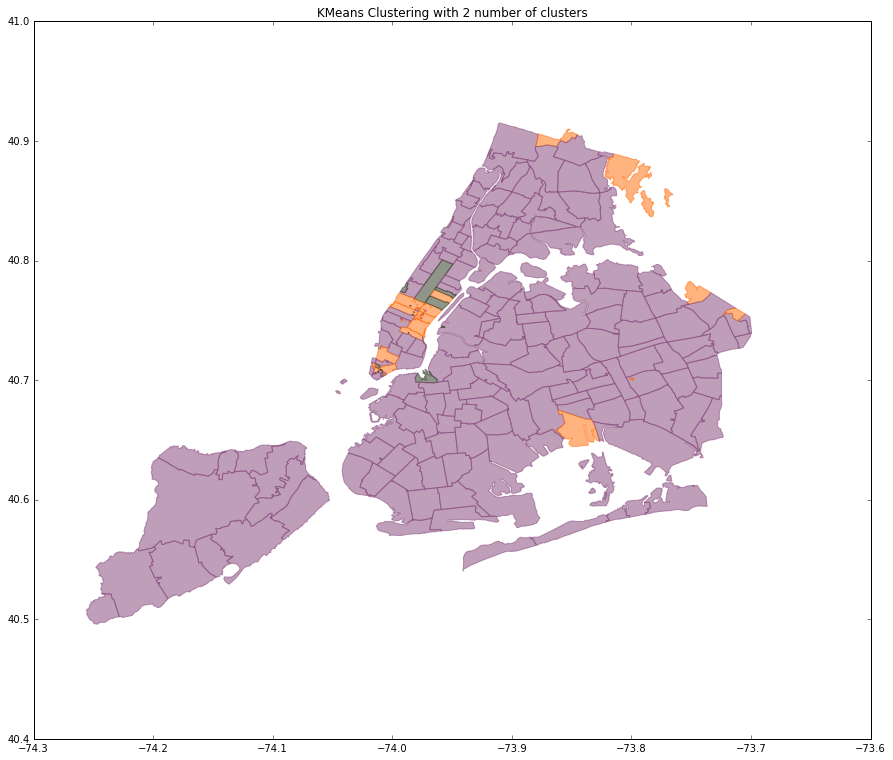

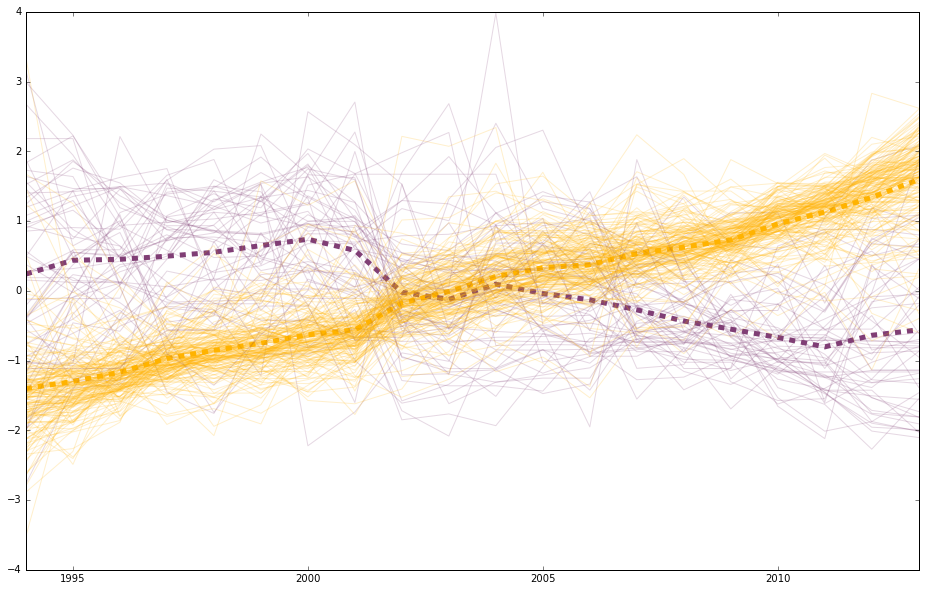

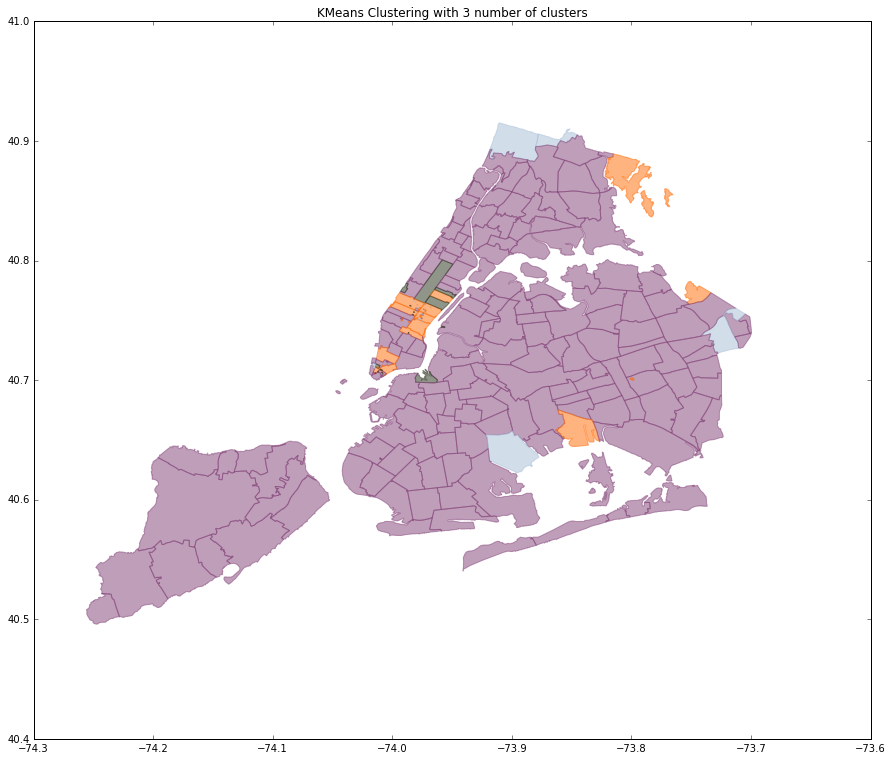

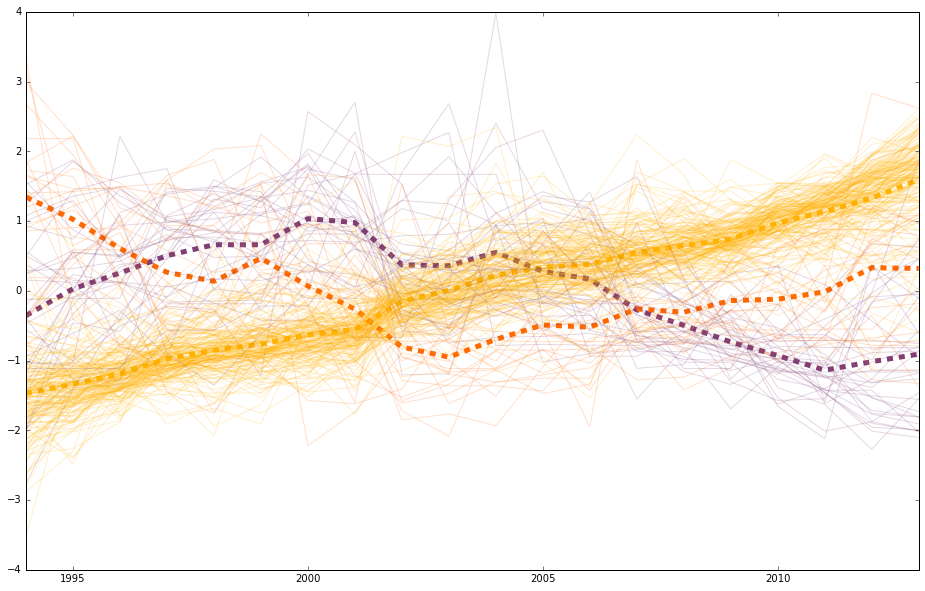

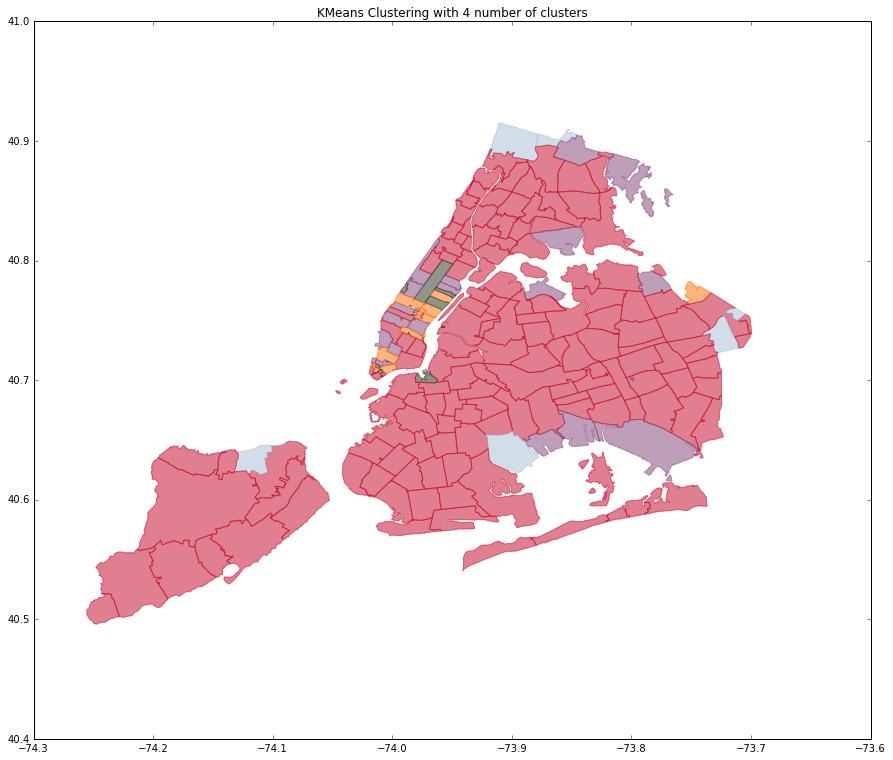

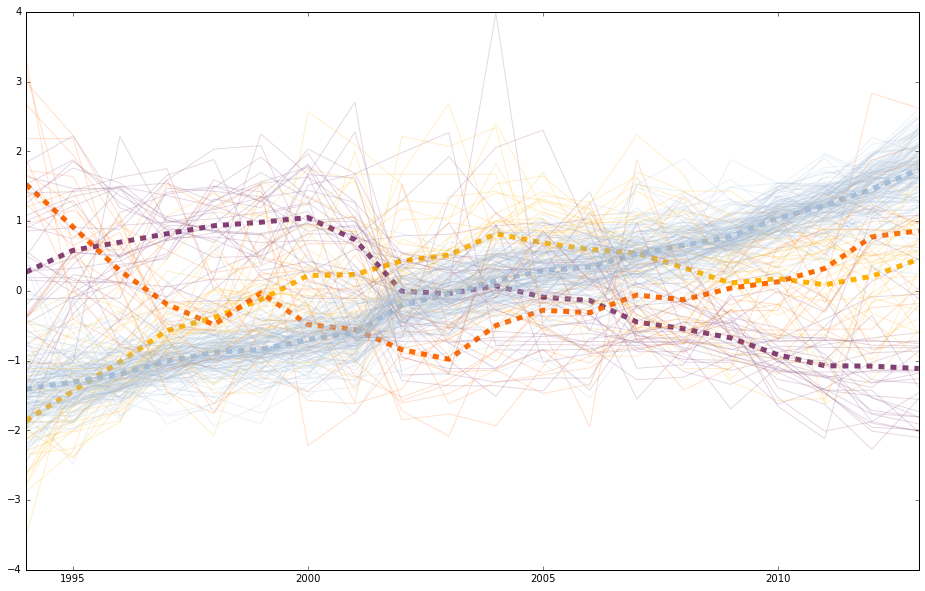

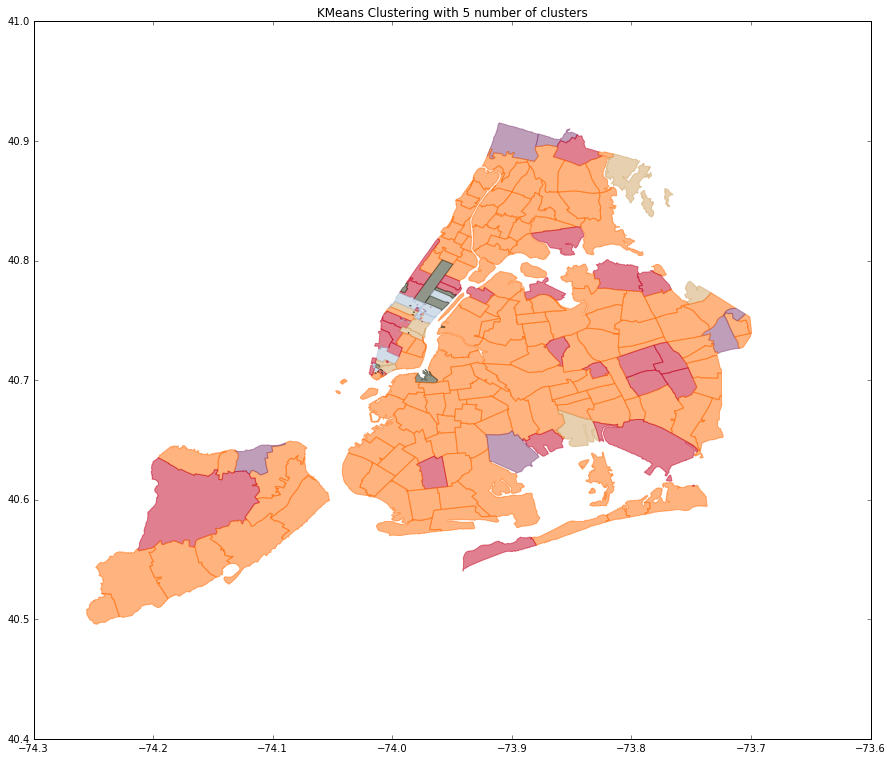

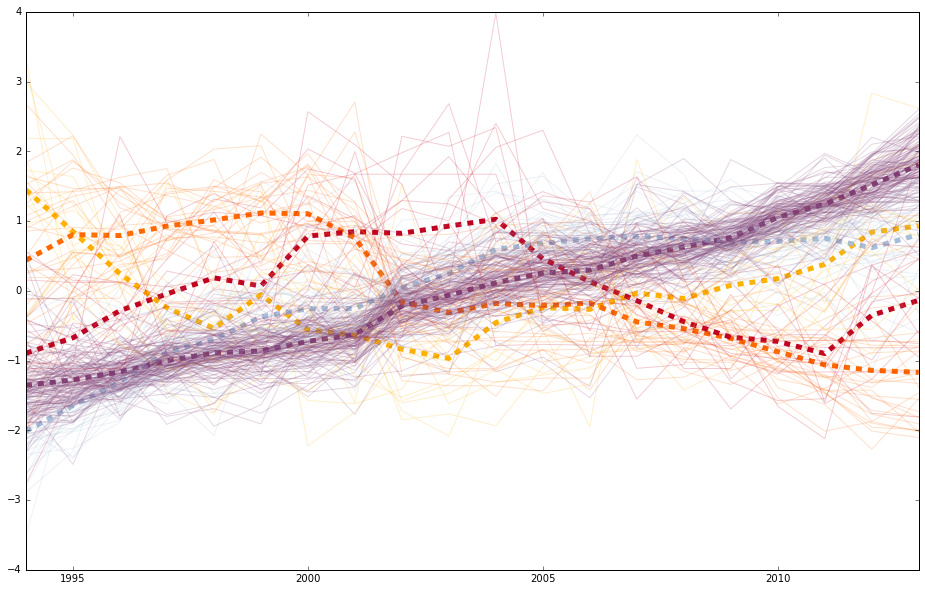

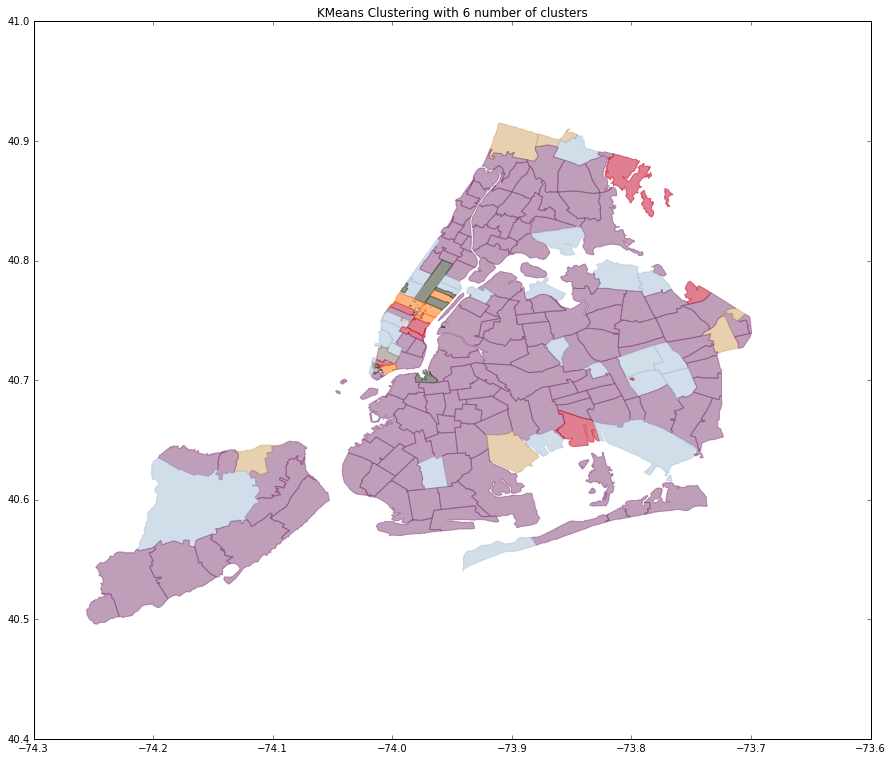

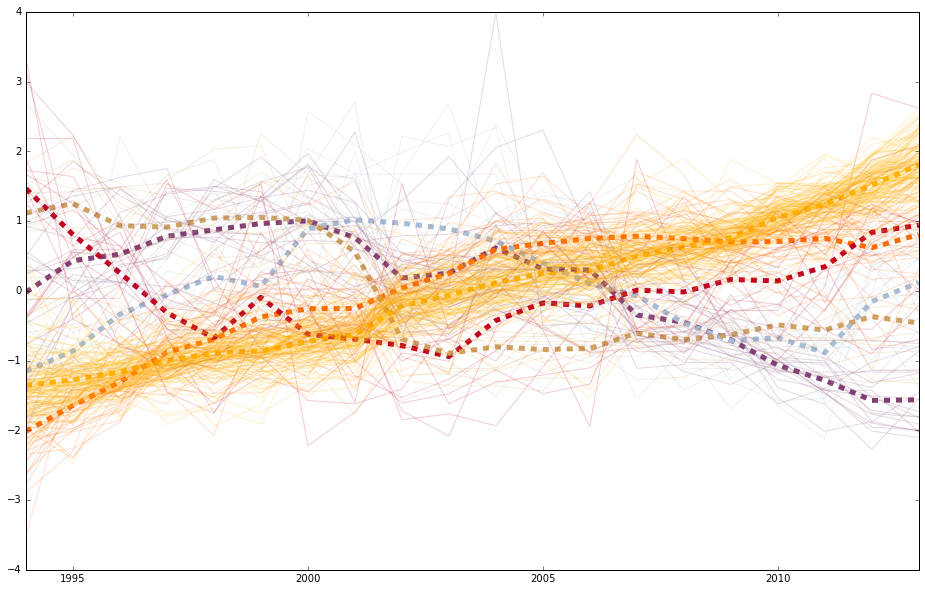

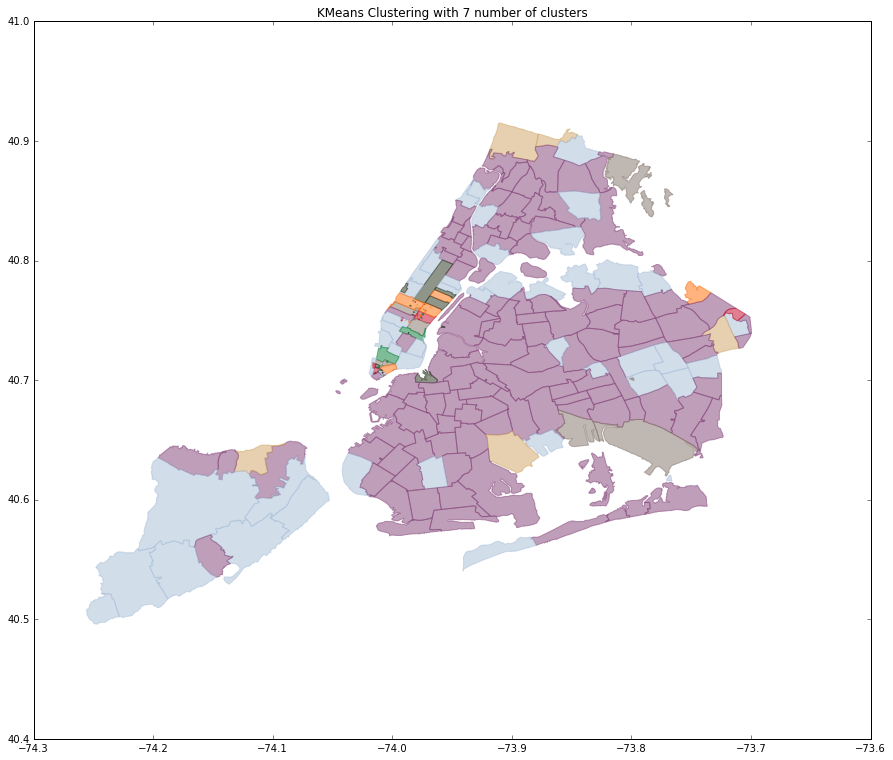

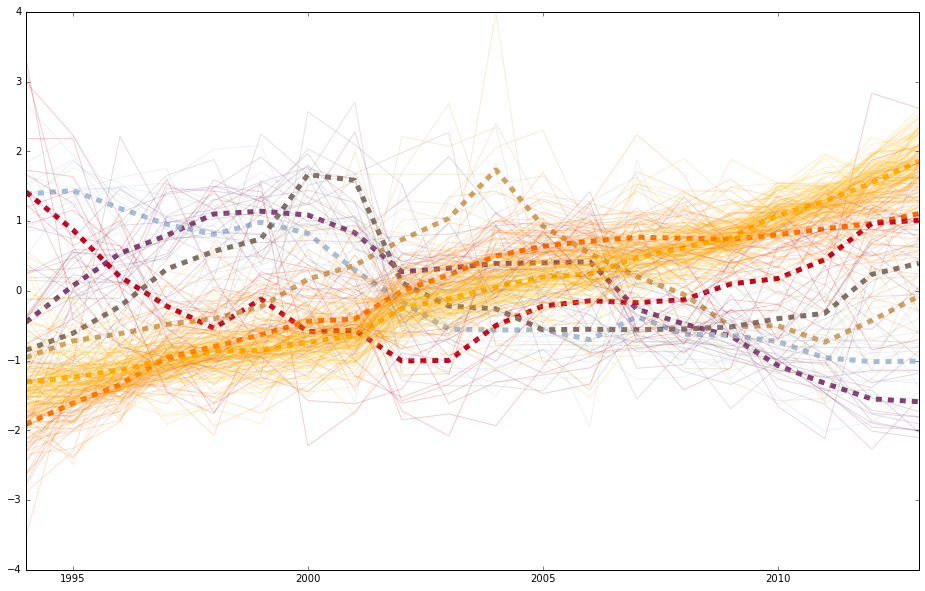

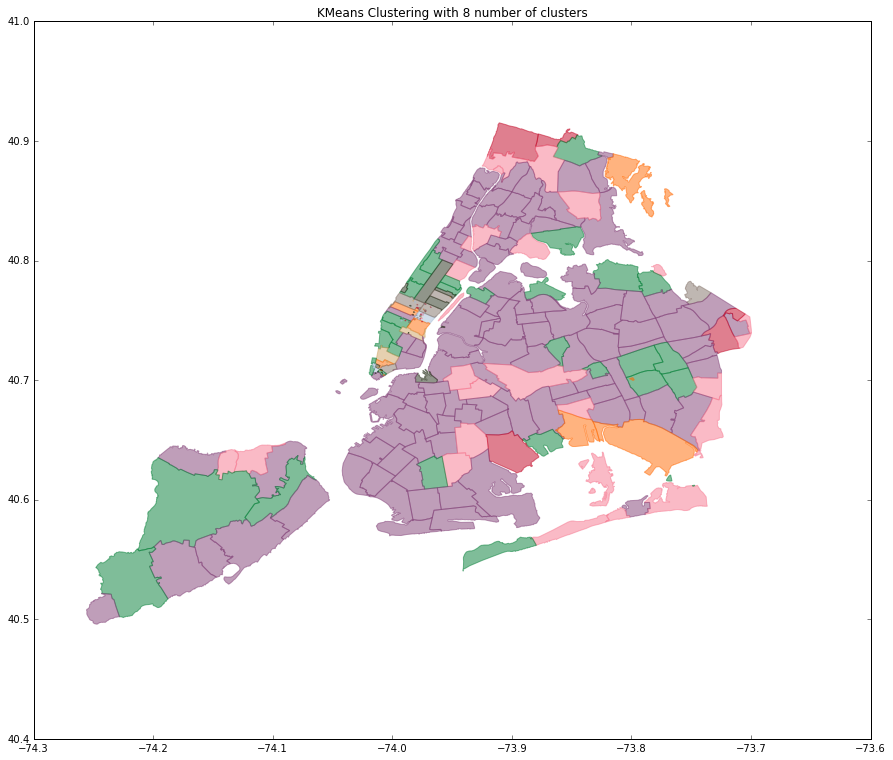

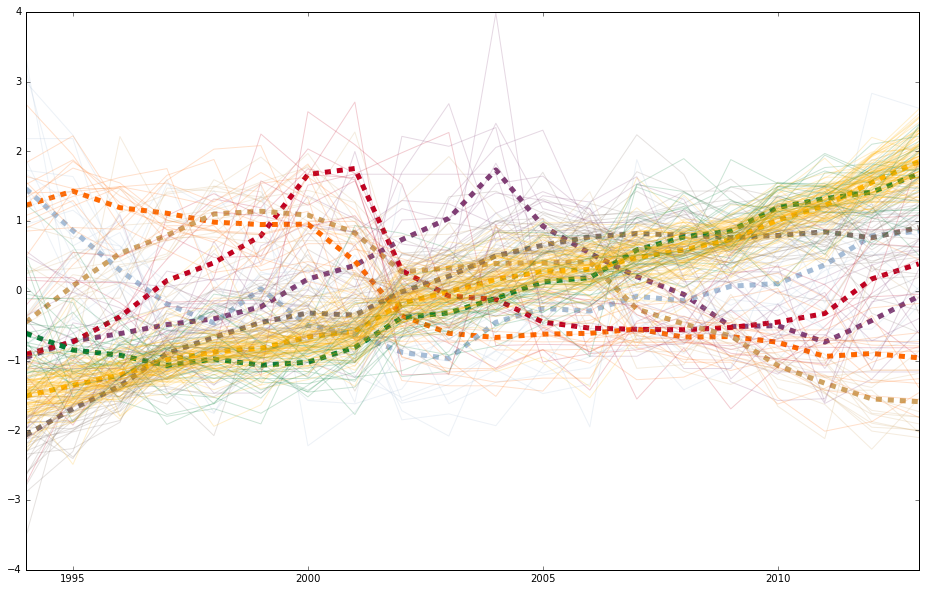

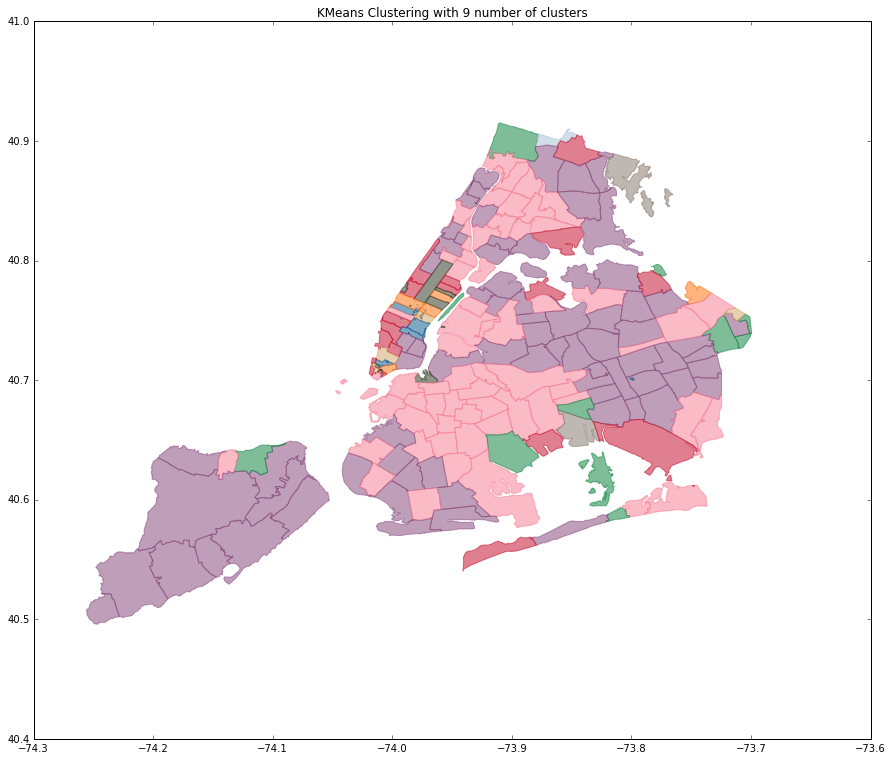

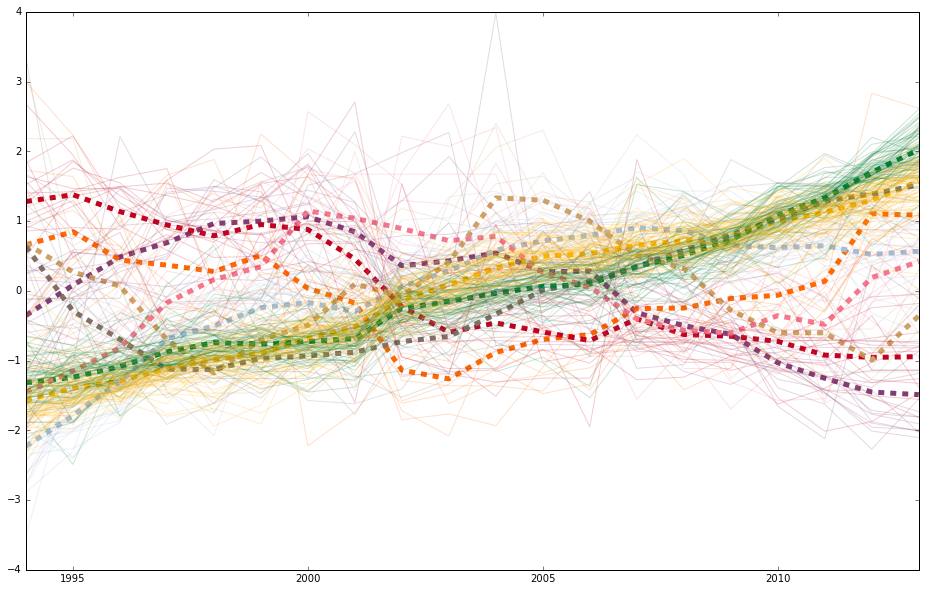

In [13]:
silhouette_scores = {}
for n in range(2,10):
    #Clustering
    kmeans = sklearn.cluster.KMeans(n_clusters=n)
    kmeans.fit(wdfez.values)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    #Silhouette score
    
    silhouette_avg = silhouette_score(wdfez.values, kmeans.labels_)
    silhouette_scores[n] = silhouette_avg
    
    #Plotting 
    cluster = labels
    clustered_zips = pd.DataFrame({'zip':wdfez.index, 'cluster':cluster})
    fig = plt.figure(figsize=(15,15)) 
    for i in nyc_sf['features']:
        poly = i['geometry']
        postcode = int(i['properties']['postalCode'])
        ax = fig.gca()
        GREEN = kelly_colors_hex[19]
        if postcode in list(wdfez.index):
            color = kelly_colors_hex[int(clustered_zips[clustered_zips['zip']==postcode]['cluster'])+1]
            ax.add_patch(PolygonPatch(poly, fc=color, ec=color, alpha=0.5, zorder=2 ))
        else:
            ax.add_patch(PolygonPatch(poly, fc=GREEN, ec=GREEN, alpha=0.5, zorder=2 ))
    ax.axis('scaled')
    import matplotlib.patches as mpatches

    ground = mpatches.Patch(color=GREEN, alpha=0.5, label='Ground')
    plt.legend()
    plt.title('KMeans Clustering with %s number of clusters'%(n))
    plt.figure(figsize=(16,10))
    plt.xlim(1994,2013)
    for i in range(len(centers)):
        plt.plot(range(1994,2014),centers[i],'--',linewidth=5,alpha=1.0,c=kelly_colors_hex[i]) 
    for i in range(len(wdfez)):
        plt.plot(wdfez.iloc[i].index, wdfez.iloc[i],c=kelly_colors_hex[labels[i]],alpha=0.2)

In [14]:
for sc in silhouette_scores:
    print('For {0} number of centers, the silhouette value is {1}'.format(sc, silhouette_scores[sc]))

For 2 number of centers, the silhouette value is 0.561611135742
For 3 number of centers, the silhouette value is 0.530531696129
For 4 number of centers, the silhouette value is 0.415116454606
For 5 number of centers, the silhouette value is 0.288806786708
For 6 number of centers, the silhouette value is 0.282790053611
For 7 number of centers, the silhouette value is 0.206584352817
For 8 number of centers, the silhouette value is 0.182938811799
For 9 number of centers, the silhouette value is 0.144494600113


[0 1]
Silhouette Coefficient: 0.56473299576
Estimated number of clusters: 2


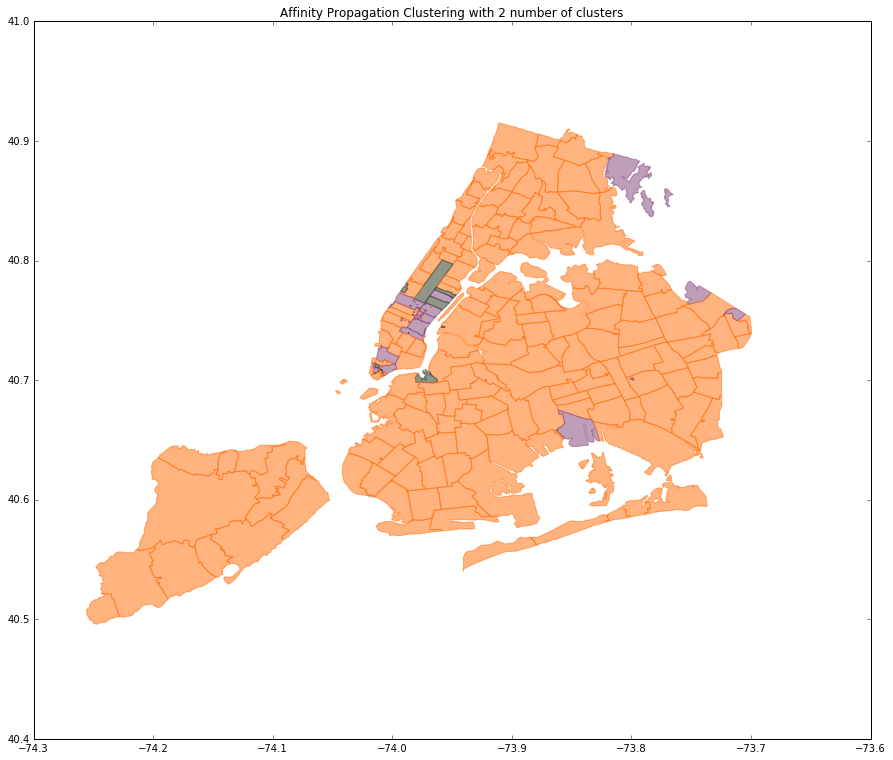

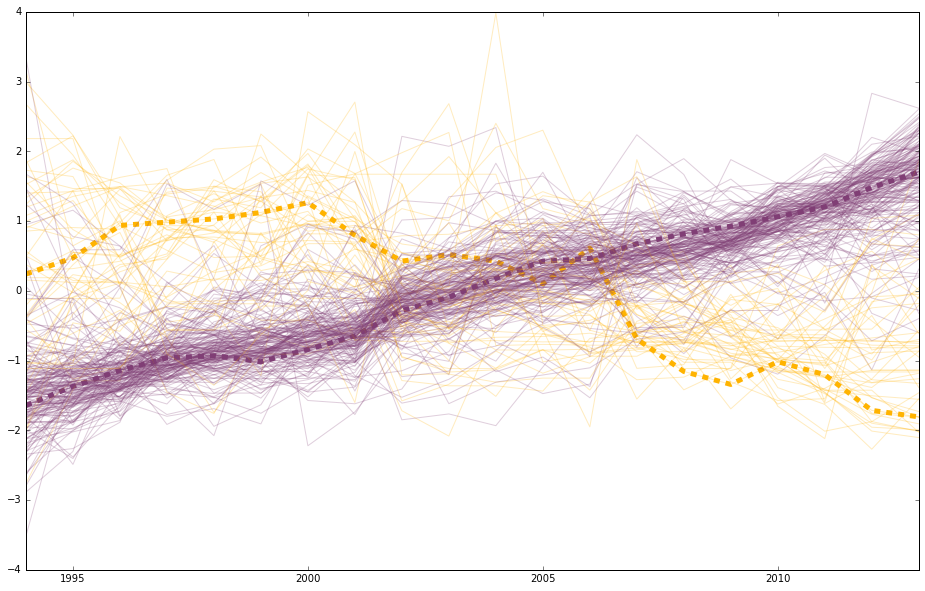

In [15]:
db = AffinityPropagation(preference=-350).fit(wdfez.values)

labels = (db.labels_).astype(int)
centers = db.cluster_centers_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print(unique(labels))
print("Silhouette Coefficient: %s" % silhouette_score(wdfez.values, labels))
print('Estimated number of clusters: %d' % n_clusters)

cluster = labels
clustered_zips = pd.DataFrame({'zip':wdfez.index, 'cluster':cluster})
fig = plt.figure(figsize=(15,15)) 
for i in nyc_sf['features']:
    poly = i['geometry']
    postcode = int(i['properties']['postalCode'])
    ax = fig.gca()
    GREEN = kelly_colors_hex[19]
    if postcode in list(wdfez.index):
        color = kelly_colors_hex[int(clustered_zips[clustered_zips['zip']==postcode]['cluster'])+1]
        ax.add_patch(PolygonPatch(poly, fc=color, ec=color, alpha=0.5, zorder=2 ))
    else:
        ax.add_patch(PolygonPatch(poly, fc=GREEN, ec=GREEN, alpha=0.5, zorder=2 ))
ax.axis('scaled')
import matplotlib.patches as mpatches

ground = mpatches.Patch(color=GREEN, alpha=0.5, label='Ground')
plt.legend()
plt.title('Affinity Propagation Clustering with %s number of clusters'%(n_clusters))
plt.figure(figsize=(16,10))
plt.xlim(1994,2013)
for i in range(len(centers)):
    plt.plot(range(1994,2014),centers[i],'--',linewidth=5,alpha=1.0,c=kelly_colors_hex[i]) 
for i in range(len(wdfez)):
    plt.plot(wdfez.iloc[i].index, wdfez.iloc[i],c=kelly_colors_hex[labels[i]],alpha=0.25)

Obtaining 2 Clusters in the second method, has better way to clustering because the silhouette score is higher.